In [1]:
import numpy as np
from scipy import stats

In [2]:
def discretize(Z, Zdim, Zmin, Zstep):
    ###
    #Discretize a variable Z using its dimension Zdim, its minimal values along each axis and the discretization steps
    res = [0]*Zdim #n-dimensional index
    for i in range(Zdim): #For each dimension
        elt = Z[i] #Extract the i-th element
        ind = int((elt - Zmin[i])//Zstep[i]) #Discretize
        res[i] = ind
    return(tuple(res)) #Return as tuple for array indexing

def DKL(f,g):
    ###
    #Calculate the DKL of two 2D pfs
    div = 0 #Initialize
    for i in range(50):
        for j in range(50):
            if g[i][j] != 0 and f[i][j] != 0: #For numerical safety we will only integrate over the support of both functions (in practice this is compliant with the definition of the DKL)
                div = div + f[i][j]
    return(div)

In [3]:
#Get the input axis
u_axis = [-2.5 + (n+0.5)*0.25 for n in range(20)]
#Load the plants obtained from the binning (warning, big files)
plant_target = np.load('plant_l06_m05.npy')
plant_actual = np.load('plant_l06_m1.npy')

In [4]:
class Pendulum():
    def __init__(self):
        self.l = 0.6
        self.m = 1
        self.max_torque = 10
        self.max_speed = 5
        self.state = np.array([0,0])
        self.last_input = None
        self.g = 9.81
        self.dt = 0.1
        self.angle_std = 3*2*np.pi/360
        self.speed_std = 0.1
        
    def random_init(self):
        ###
        #Random initialization
        self.state = np.array([np.random.uniform(-np.pi, np.pi),np.random.uniform(-sefl.max_speed, self.max_speed)])
        
    def step(self, u):
        #Simulation step
        u = np.clip(u, -self.max_torque, self.max_torque) #Clip the input as safety
        self.last_input = u
        accel = u/(self.m*self.l*self.l) + self.g*np.sin(self.state[0])/self.l #Dynamics for the acceleration
        
        speed = self.state[1]
        angle = self.state[0]
        
        new_speed = speed + accel*self.dt + np.random.normal(0,self.speed_std) #Calculate the new speed
        new_speed = np.clip(new_speed, -self.max_speed, self.max_speed) #Clip the speed as safety (in practice the bounds were chosen to ensure this very rarely happens)
        
        new_angle = angle + speed*self.dt + np.random.normal(0,self.angle_std) #New angle
        if new_angle < -np.pi: #Angle is modulo 2\pi
            new_angle = new_angle + 2*np.pi
        if new_angle > np.pi:
            new_angle = new_angle - 2*np.pi
        
        self.state = np.array([new_angle, new_speed])
        
    def set_state(self, angle, speed):
        ###
        #Explicitely set the state
        speed = np.clip(speed, -self.max_speed, self.max_speed)
        if angle < -np.pi:
            angle = angle + 2*np.pi
        if angle > np.pi:
            angle = angle - 2*np.pi
        self.state = np.array([angle, speed])

        
    def FPD_step(self, u):
        ###
        #Perform an FPD step given an expert input, by first getting the corresponding pf and then applying the FPD solution
        tpf = stats.norm.pdf(u_axis, u, 0.2) #Input pf
        S = np.sum(tpf) #Normalizing input pf
        target_pf = [x/S for x in tpf]
        
        ind = discretize(self.state, 2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state index for DKL calculation
        
        pf = np.zeros(20) #Initialize pf
        for i in range(20):
            f = plant_actual[ind[0],ind[1],i] #Get the actual and demonstrator plants from the binned data
            g = plant_target[ind[0],ind[1],i]
            pf[i] = target_pf[i]*np.exp(-DKL(f,g)) #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(pf) #Normalize resulting policy
        pf = [x/S2 for x in pf]
        
        action = np.random.choice(u_axis, p=pf) #Select a random action from the new policy
        
        self.step(action) #Simulation step

In [5]:
###
#The following cells are dedicated to building the MPC controller used for the expert policy. Refer to the MPC file for details

In [6]:
import numpy as np
import sys
from casadi import *
import do_mpc


model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [7]:
theta = model.set_variable(var_type='_x', var_name='theta', shape=(1,1))
dtheta = model.set_variable(var_type='_x', var_name='dtheta', shape=(1,1))

u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))

In [8]:
m = 0.5
l = 0.6

g = 9.81

In [9]:
model.set_rhs('theta',dtheta)
model.set_rhs('dtheta', g*sin(theta)/l + u/(m*l*l))

In [10]:
model.setup()

In [11]:
mpc = do_mpc.controller.MPC(model)

In [12]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 0,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [13]:
l_term = theta*theta + 0.1*dtheta*dtheta
m_term = theta*theta + 0.5*dtheta*dtheta
mpc.set_objective(mterm=m_term, lterm=l_term)

In [14]:
mpc.bounds['lower','_u', 'u'] = -2
mpc.bounds['upper','_u', 'u'] = 2

In [15]:
mpc.setup()

/usr/local/lib/python3.8/site-packages/do_mpc/controller.py:898: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [16]:
x0 = np.array([np.pi, 0]).reshape(-1,1)
mpc.x0 = x0

In [17]:
mpc.set_initial_guess()

In [18]:
mpc.reset_history()

In [19]:
%%capture
nSims = 10
nSteps = 300
fullH = np.zeros((nSims,nSteps-1))
uH = np.zeros((nSims,nSteps-1))

for j in range(nSims): #Perform 10 simulations
    hist = [[0,0]]*nSteps
    uhist = [0]*nSteps

    P1 = Pendulum() #Initialize a new pendulum
    P1.m = m
    P1.set_state(np.pi,0) #Set the new pendulum to the initial state
    mpc.reset_history()
    for i in range(nSteps-1): #For each step in the simulation
        state = P1.state #Get the state
        hist[i+1] = state #Log the state
        x0 = state.reshape(-1,1)
        u0 = mpc.make_step(x0) #Get the expert action
        u = u0[0][0]
        P1.FPD_step(u) #Perform a FPD step: get expert policy from action, derive actual policy, sample, simulate
        uhist[i] = u #Log action
    fullH[j] = [x[0] for x in hist[1:]]
    uH[j] = uhist[:299]

In [20]:
means = [0]*(nSteps-1) #Average and std over the simulations
stds = [0]*(nSteps-1)
for i in range(nSteps-1):
    means[i] = np.mean(fullH[:,i])
    stds[i] = np.std(fullH[:,i])

Text(0, 0.5, 'Angular position')

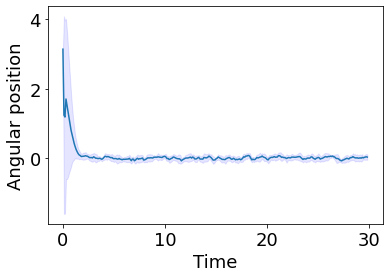

In [21]:
from matplotlib import pyplot as plt
from pylab import rcParams
plt.rcParams.update({'font.size': 18})


x = np.array([x/10 for x in range(nSteps-1)])
y = np.array(means)
ci = np.array(stds)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
#ax.set_title('FPD input')
ax.set_xlabel('Time')
ax.set_ylabel('Angular position')
#plt.savefig('fpd_angle_ci.png', bbox_inches = 'tight')

In [22]:
umeans = [0]*(nSteps-1)
ustds = [0]*(nSteps-1)
for i in range(nSteps-1):
    umeans[i] = np.mean(uH[:,i])
    ustds[i] = np.std(uH[:,i])

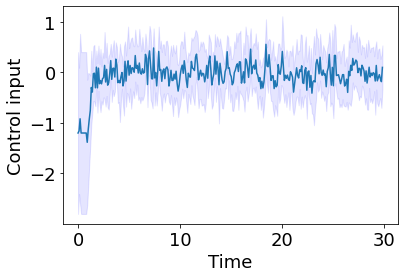

In [23]:
from matplotlib import pyplot as plt

x = np.array([x/10 for x in range(nSteps-1)])
y = np.array(umeans)
ci = np.array(ustds)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
#ax.set_title('FPD input')
ax.set_xlabel('Time')
ax.set_ylabel('Control input')
plt.savefig('fpd_input_ci.png', bbox_inches = 'tight')